<a href="https://www.kaggle.com/code/joshuacurtiswebb/simuledge?scriptVersionId=142574914" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
from spx_strategies import *

#########################
# VERSION
#########################
notebook_name = 'simuledge'
notebook_v=0

#########################
# DATA CONFIGURATION
#########################
load_cboe = True
cboe_years = [2014]
load_tradier = False

#########################
# STUDY CONFIGURATION
#########################
op_sel = DeltaOptionSelector
ent_pol_study = OptionSelectorStaticEntryPolicy
ex_pol_study = HoldToExpStaticExitPolicy
study_param_ranges = {
    'sp':(0.003,0.5),
    'lp':(0.002,''),
    'sc':(0.003,0.5),
    'lc':(0.002,''),
}

configs_ent_pol = {    
    'dte':1,
    'pt':'16:00:00'}

configs_ex_pol ={
}

configs_strat ={
    'comm':1.5,
    'ipv': 0.2
}
configs_strat['ds'] = 'tradier' if load_tradier else 'cboe'

configs = {}

# IPV will be overwritten when data is loaded
initial_portfolio_value = 1


num_trials = 2000


In [2]:
import logging
import sys
import pandas as pd
import numpy as np
from datetime import datetime, date, timedelta, time
import matplotlib.pyplot as plt
from time import perf_counter
import optuna
import os
from shutil import copy
from textwrap import wrap
pd.set_option("max_columns", 200)

#copy db
cwd = os.getcwd()
output_spx_spread_backtester_path = '/kaggle/input/simuledge/'
dir_list = os.listdir(output_spx_spread_backtester_path)
files = [f for f in dir_list if os.path.isfile(output_spx_spread_backtester_path+f) and ".db" in f] #Filtering only the db files.
for f in files:
    if not os.path.exists(cwd+'/'+f):
        print(f"Copying db file to output : {f}")
        copy(output_spx_spread_backtester_path+f,cwd+'/'+f)


Copying db file to output : DOS_OSSEntryP__sp_0.005_0.45_lp_0.002__sc_0.005_0.45_lc_0.002__dte_1_pt_16:00:00_HTESExitP_comm_1.5_ipv_0.2_ds_tradier_230714_230831_spx_st_0_simuledge_0.db
Copying db file to output : optimal-short-ic-study_2023-2023_1DTE_2023-08-26-22.db
Copying db file to output : optimal-short-straddle-study_2023-2023_1DTE_2023-07-31-20.db
Copying db file to output : optimal-short-straddle-study_2023-2023_1DTE_2023-08-13-22.db
Copying db file to output : optimal-short-straddle-study_2023-2023_1DTE_2023-08-14-22.db
Copying db file to output : optimal-short-ic-study_2023-2023_1DTE_2023-08-23-22.db
Copying db file to output : DOS_OSSEntryP_sp_0.005_0.45_lp_0.002__sc_0.005_0.45_lc_0.002__dte_1_pt_16:00:00_HTESExitP_comm_1.5_ipv_0.2_ds_tradier230714_230831_spx_st_0_simuledge_0.db
Copying db file to output : optimal-short-straddle-study_2023-2023_1DTE_2023-08-01-15.db
Copying db file to output : optimal-short-straddle-study_2023-2023_1DTE_2023-08-17-22.db
Copying db file to ou

In [3]:
def ipv_transform(df, scaling_factor):
    if 'price' not in df.columns:
        raise Exception("Need 'price' in dataframe")
        
    return df.loc[1,'price']*scaling_factor*100


In [4]:
if load_cboe:
    files = []
    for cboe_year in cboe_years:
        files.append(f"/kaggle/input/cboedailytrimspxcboe202202020939/cboe_pyvollib_spx_{cboe_year}_1dte_all.csv")
        
    dfs = []
    for f in files:   
        df = pd.read_csv(f, index_col=None, header=0, dtype={'type':'category','quote_time':'category'})
        dfs.append(df)

    df = pd.concat(dfs, axis=0, ignore_index=True)
    df['expiration']=pd.to_datetime(df['expiration'],infer_datetime_format=True)
    df['quote_date']=pd.to_datetime(df['quote_date'],infer_datetime_format=True)
    df['delta'] = df['delta'].abs()

    if 'dte' not in df:
        raise Exception("dte must be present")

    df_ty = pd.read_csv(f"/kaggle/input/treasury-yield-13w-2012-2022/13_week_treasury_yield.csv", index_col=None, header=0)
    df_ty['Date'] = pd.to_datetime(df_ty['Date'])
    
    df_irx = df_ty

In [5]:
if load_tradier:
    for dirname, _, filenames in os.walk('/kaggle/input/spx-option-chain-1dte-all-times'):
        for f in filenames:
            if 'spx' in f:
                df = pd.read_csv(os.path.join(dirname, f), index_col=None, header=0)
                df.rename(columns={'underlying':'price'},inplace=True)
                df.drop(columns=['Unnamed: 0'], inplace=True)
                df['expiration']=pd.to_datetime(df['expiration'],infer_datetime_format=True)
                df['quote_date']=pd.to_datetime(df['quote_date'],infer_datetime_format=True)
                df['delta'] = df['delta'].abs()
            elif 'irx' in f:
                df_irx = pd.read_csv(os.path.join(dirname, f), index_col=None, header=0)
                df_irx.rename(columns={'close':'Adj Close','quote_date':'Date'},inplace=True)
                df_irx['Adj Close']*= 100
                df_irx['Date']=pd.to_datetime(df_irx['Date'],infer_datetime_format=True)
                df_irx['quote_time']=pd.to_datetime(df_irx['quote_time'],infer_datetime_format=True)
                df_irx = df_irx.loc[df_irx.groupby('Date')['quote_time'].idxmax()]
                df_irx.drop(columns=['Unnamed: 0', 'quote_time'], inplace=True)


In [6]:
# For whatever data we've loaded, create an initial portfolio value
initial_portfolio_value = ipv_transform(df, configs_strat['ipv'])

# Backtest Optimization

In [7]:
# purchase_time = '16:01:00'
# dos = DeltaOptionSelector(short_puts=0.04, short_calls=0.02)
# # dos = YieldOptionSelector(short_puts=0.0006, short_calls=0.0003, ipv=initial_portfolio_value)
# ent_pol=OptionSelectorStaticEntryPolicy(1, purchase_time, dos)
# #ex_pol = HoldToExpStaticExitPolicy('16:00:00')
# ex_pol = MaxLossDynamicExitPolicy(1.5)
# strat = StaticEntryDynamicExitStrategy(commission, df_irx, initial_portfolio_value, ent_pol, ex_pol, debug=True)
# strat.evaluate(df)


In [8]:
def run_backtest(strat, df):
    return strat.evaluate(df)['Risk Adj Cumulative Return On Scaled Max Risk']

In [9]:
def objective(trial, df, purchase_time):
    delta_sp_trial = trial.suggest_float('sp', study_param_ranges['sp'][0], study_param_ranges['sp'][1])
    delta_lp_trial = trial.suggest_float('lp', study_param_ranges['lp'][0], delta_sp_trial)
    delta_sc_trial = trial.suggest_float('sc', study_param_ranges['sc'][0], study_param_ranges['sc'][1])
    delta_lc_trial = trial.suggest_float('lc', study_param_ranges['lc'][0], delta_sc_trial)
   
    dos = op_sel(short_puts=delta_sp_trial, long_puts=delta_lp_trial,short_calls=delta_sc_trial, long_calls=delta_lc_trial)
    ent_pol=ent_pol_study(configs_ent_pol['dte'], configs_ent_pol['pt'], dos)
    
    ex_pol = ex_pol_study()

    strategy = StaticEntryStaticExitStrategy(configs_strat['comm'], df_irx, initial_portfolio_value, ent_pol, ex_pol, debug=False)
    score = run_backtest(strategy, df)
    return score

In [10]:
study_name = get_study_name(op_sel, ent_pol_study, study_param_ranges, 
                   configs_ent_pol, ex_pol_study, configs_ex_pol,
                   configs_strat, configs, df, spx_strat_v,
                   notebook_name, notebook_v
                  )
storage_name = "sqlite:///{}.db".format(study_name)
study = optuna.create_study(direction = "maximize", study_name=study_name, storage=storage_name, load_if_exists=True)
study.optimize(lambda trial: objective(trial, df, configs_ent_pol['pt']), n_trials = num_trials)
trial = study.best_trial
print("Best Score: ", trial.value)
print("Best Params: ")
for key, value in trial.params.items():
    print("  {}: {}".format(key, value))

[I 2023-09-10 23:46:28,044] A new study created in RDB with name: DOS_OSSEntryP__sp_0.003_0.5_lp_0.002__sc_0.003_0.5_lc_0.002__dte_1_pt_16:00:00_HTESExitP_comm_1.5_ipv_0.2_ds_cboe_140102_141231_spx_st_0_simuledge_0
[I 2023-09-10 23:46:29,136] Trial 0 finished with value: -6.3 and parameters: {'sp': 0.42504798487955203, 'lp': 0.22710291733644583, 'sc': 0.20451010706974984, 'lc': 0.0490093861834839}. Best is trial 0 with value: -6.3.
[I 2023-09-10 23:46:30,064] Trial 1 finished with value: 13.4 and parameters: {'sp': 0.07993472571954607, 'lp': 0.0025502368130280737, 'sc': 0.06220845798651298, 'lc': 0.004973166555387156}. Best is trial 1 with value: 13.4.
[I 2023-09-10 23:46:30,989] Trial 2 finished with value: -10.626 and parameters: {'sp': 0.41131674466409496, 'lp': 0.2533379290402685, 'sc': 0.30050792180329877, 'lc': 0.2350742965425672}. Best is trial 1 with value: 13.4.
[I 2023-09-10 23:46:31,914] Trial 3 finished with value: 2.359 and parameters: {'sp': 0.15845635362352534, 'lp': 0.1

Best Score:  inf
Best Params: 
  lc: 0.002896705158597734
  lp: 0.002152340129282787
  sc: 0.0030066949794573944
  sp: 0.013172427549881696


# Backtest with current best score

/kaggle/usr/lib/spx_strategies/spx_strategies.py:184: RuntimeWarning: divide by zero encountered in double_scalars
  dict_results['Risk Adj Cumulative Return On Scaled Max Risk'] = round(dict_results['Cumulative Return']/dict_results['Std Dev of Return on Max Risk'],3)


*****  BACKTEST RESULTS  ****
Cumulative Return                                 0.008
Max Drawdown                                     -0.035
Mean Net Max Loss                             11582.073
Max Net Max Loss                                86037.5
Mean Return on Max Risk                             0.0
Std Dev of Return on Max Risk                       0.0
Risk Adj Cumulative Return On Scaled Max Risk       inf
Trading Days                                         41
Wins                                                 30
Losses                                               11
Breakeven                                             0
Win/Loss Ratio                                   73.171
Mean Win                                          2.667
Mean Loss                                        -7.818
Mean Net Trans                                   -0.146
Std Dev of Net Trans                              7.404
Max Loss                                          -40.5
Max Win           

,trade_date,expiration,trade_count,strike_sp_0,strike_sc_0,strike_lc_0,strike_lp_0,delta_sp_target_0,delta_sp_0,collected_sp_0,delta_sc_target_0,delta_sc_0,collected_sc_0,delta_lc_target_0,delta_lc_0,collected_lc_0,delta_lp_target_0,delta_lp_0,collected_lp_0,collected,lost_c,lost_p,price,commission,lost,net,portfolio_value,net_cumsum,transaction_return,cum_return,daily_risk_free_return,gross_max_loss,net_max_loss,return_on_max_risk,scaled_return_on_max_risk
0,2014-01-02,2014-01-03,2,1750.0,1885.0,1885.0,1655.0,0.013172,0.012664,10.0,0.003007,0.002795,0.0,0.002897,0.002795,0.0,0.002152,0.001975,-5.0,5.0,0.0,0.0,1831.47,3.0,0.0,2.0,36845.6,2.0,0.000054,0.000054,2.301587e-06,9500.0,9495.0,0.000211,1.000004
1,2014-01-09,2014-01-10,2,1770.0,1895.0,1895.0,1710.0,0.013172,0.012378,10.0,0.003007,0.002743,0.0,0.002897,0.002743,0.0,0.002152,0.002090,-5.0,5.0,0.0,0.0,1842.37,3.0,0.0,2.0,36847.6,4.0,0.000054,0.000109,1.309524e-06,6000.0,5995.0,0.000334,1.000007
2,2014-01-23,2014-01-24,2,1750.0,1885.0,1885.0,1635.0,0.013172,0.012910,10.0,0.003007,0.002670,0.0,0.002897,0.002670,0.0,0.002152,0.002062,-5.0,5.0,0.0,0.0,1790.75,3.0,0.0,2.0,36849.6,6.0,0.000054,0.000163,1.190476e-06,11500.0,11495.0,0.000174,1.000003
3,2014-01-30,2014-01-31,4,1720.0,1855.0,1865.0,1615.0,0.013172,0.011699,10.0,0.003007,0.002944,0.0,0.002897,0.002840,-5.0,0.002152,0.002123,-5.0,0.0,0.0,0.0,1782.48,6.0,0.0,-6.0,36843.6,0.0,-0.000163,0.000000,5.952381e-07,10500.0,10500.0,-0.000571,0.999989
4,2014-02-06,2014-02-07,2,1685.0,1840.0,1840.0,1605.0,0.013172,0.011967,12.5,0.003007,0.002787,0.0,0.002897,0.002787,0.0,0.002152,0.001547,-5.0,7.5,0.0,0.0,1796.64,3.0,0.0,4.5,36848.1,4.5,0.000122,0.000122,2.380952e-06,8000.0,7992.5,0.000563,1.000011
5,2014-02-13,2014-02-14,2,1755.0,1905.0,1905.0,1645.0,0.013172,0.010777,10.0,0.003007,0.002594,0.0,0.002897,0.002594,0.0,0.002152,0.002020,-5.0,5.0,0.0,0.0,1838.51,3.0,0.0,2.0,36850.1,6.5,0.000054,0.000176,9.920635e-07,11000.0,10995.0,0.000182,1.000004
6,2014-02-27,2014-02-28,2,1785.0,1915.0,1915.0,1700.0,0.013172,0.012327,10.0,0.003007,0.002828,0.0,0.002897,0.002828,0.0,0.002152,0.001974,-5.0,5.0,0.0,0.0,1859.02,3.0,0.0,2.0,36852.1,8.5,0.000054,0.000231,1.388889e-06,8500.0,8495.0,0.000235,1.000005
7,2014-03-06,2014-03-07,4,1805.0,2010.0,1930.0,1635.0,0.013172,0.012926,10.0,0.003007,0.003005,5.0,0.002897,0.002772,-5.0,0.002152,0.001631,-5.0,5.0,0.0,0.0,1877.83,6.0,0.0,-1.0,36851.1,7.5,-0.000027,0.000204,1.785714e-06,17000.0,16995.0,-0.000059,0.999999
8,2014-03-13,2014-03-14,2,1745.0,1900.0,1900.0,1585.0,0.013172,0.011982,15.0,0.003007,0.002855,0.0,0.002897,0.002855,0.0,0.002152,0.002041,-10.0,5.0,0.0,0.0,1840.81,3.0,0.0,2.0,36853.1,9.5,0.000054,0.000258,1.587302e-06,16000.0,15995.0,0.000125,1.000003
9,2014-03-27,2014-03-28,2,1780.0,1900.0,1900.0,1645.0,0.013172,0.012065,10.0,0.003007,0.002869,0.0,0.002897,0.002869,0.0,0.002152,0.002152,-5.0,5.0,0.0,0.0,1857.39,3.0,0.0,2.0,36855.1,11.5,0.000054,0.000312,1.309524e-06,13500.0,13495.0,0.000148,1.000003


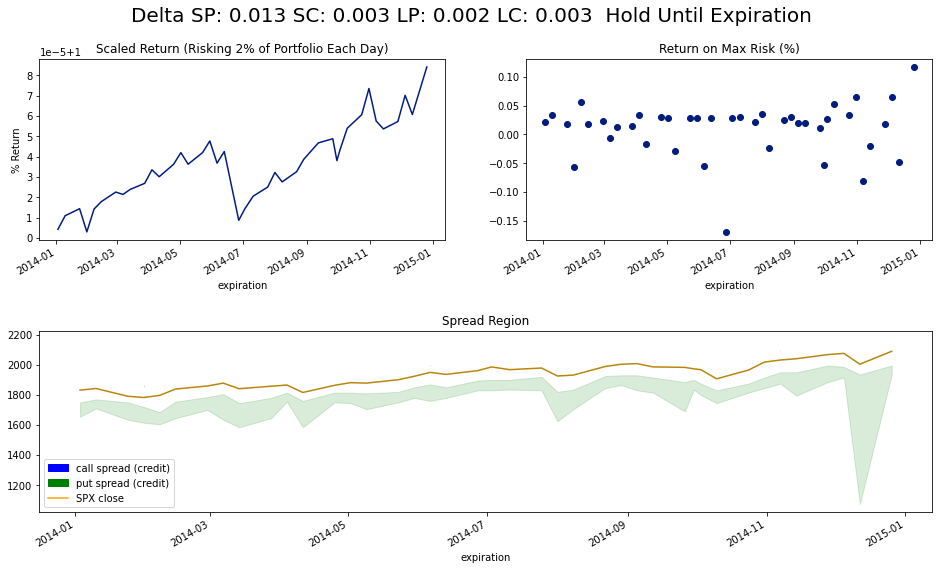

In [11]:
dos = DeltaOptionSelector(short_puts=trial.params['sp'],short_calls=trial.params['sc'], long_puts=trial.params['lp'],long_calls=trial.params['lc'])
ent_pol=OptionSelectorStaticEntryPolicy(1, configs_ent_pol['pt'], dos)
ex_pol = HoldToExpStaticExitPolicy()
strat = StaticEntryStaticExitStrategy(configs_strat['comm'], df_irx, initial_portfolio_value, ent_pol, ex_pol, debug=True)
strat.evaluate(df)

strat.df_trades

# Strikes for tomorrow with current best

In [12]:
next_exp = df['expiration'].max()
quote_date_next_exp = df[(df['expiration']==df['expiration'].max())&(df['quote_date']!=df['expiration'].max())]['quote_date'].iloc[0]
df_trades = pd.DataFrame([{'trade_date':quote_date_next_exp,'expiration':next_exp}])
df_filt = df[
    (df['expiration']==df['expiration'].max())&
    (df['quote_date']!=df['expiration'].max())&
    (df['quote_time']=='16:00:00')
]

In [13]:
dos = DeltaOptionSelector(short_puts=trial.params['sp'],short_calls=trial.params['sc'], long_puts=trial.params['lp'],long_calls=trial.params['lc'])
ent_pol=OptionSelectorStaticEntryPolicy(1, '16:01:00', dos)
dos.populateTrades(df_filt,df_trades,ent_pol.get_contract_strike)

,trade_date,expiration,delta_sp_target_0,strike_sp_0,delta_sp_0,collected_sp_0,delta_sc_target_0,strike_sc_0,delta_sc_0,collected_sc_0,delta_lc_target_0,strike_lc_0,delta_lc_0,collected_lc_0,delta_lp_target_0,strike_lp_0,delta_lp_0,collected_lp_0,trade_count,collected
0,2014-12-30,2014-12-31,0.013172,1985.0,0.012426,12.5,0.003007,2145.0,0.002837,0.0,0.002897,2145.0,0.002837,0.0,0.002152,1905.0,0.002004,-5.0,2,7.5


# Strikes following the 4/2 Strategy

In [14]:
dos = DeltaOptionSelector(short_puts=0.04,short_calls=0.02)
ent_pol=OptionSelectorStaticEntryPolicy(1, '16:01:00', dos)
df_trades = pd.DataFrame([{'trade_date':quote_date_next_exp,'expiration':next_exp}])
dos.populateTrades(df_filt,df_trades,ent_pol.get_contract_strike)

,trade_date,expiration,delta_sp_target_0,strike_sp_0,delta_sp_0,collected_sp_0,delta_sc_target_0,strike_sc_0,delta_sc_0,collected_sc_0,trade_count,collected
0,2014-12-30,2014-12-31,0.04,2030.0,0.033185,25.0,0.02,2115.0,0.016893,10.0,2,35.0
